<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Testing-pipeline" data-toc-modified-id="Testing-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Testing pipeline</a></span></li><li><span><a href="#Comparison-Sig-Kernel-and-RBF-Kernel" data-toc-modified-id="Comparison-Sig-Kernel-and-RBF-Kernel-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison Sig-Kernel and RBF-Kernel</a></span></li></ul></div>

In [125]:
from importlib import reload
import numpy as np
import data_generators.ellipsis
from data_generators import ellipsis
import utils
from utils import *
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features
from signature_features import *

# Description



# Testing pipeline

**Generate data**

In [327]:
reload(ellipsis)

N_bags = 200
N_items = 15
tspan = np.linspace(0.0, 2*np.pi, 501)
spec_param = {'a':[1.,3.], 'b':[1.,3.]} #,'stdv_noise':[None]}

example = ellipsis.Ellipsis()
example.generate_data(N_bags=N_bags,N_items=N_items, t_span = tspan,spec_param=spec_param, stdv_pos=0., stdv_noise=0.3)
example.e_ang()


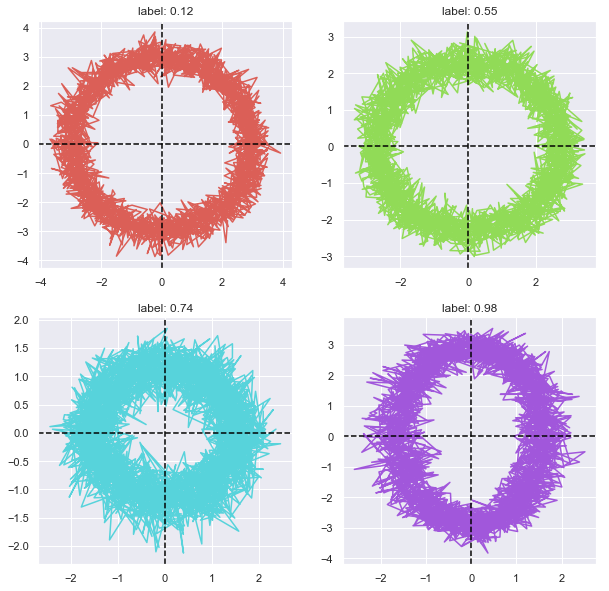

In [328]:
example.plot(N=2)

**Visualize the variability between bags**

We order bags by their labels. We choose N bags amongst all bags, and plot one sample per bag. We also represent a circle which corresponds to $e=0$. We recentre the ellipsis. 

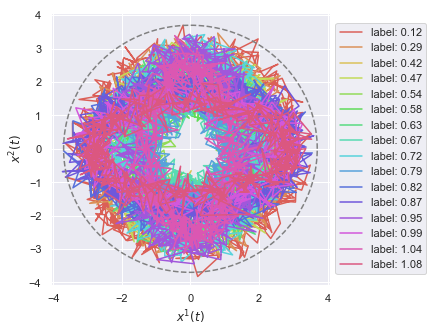

In [329]:
example.one_plot(N=16)

**Linear relationship between vector norm and label?**

We have 2D paths $x_t=(x^1_t,x^2_t)$. Subsampling these paths yields matrices $\mathbf{x}=(\mathbf{x}^1,\mathbf{x}^2)$. To perform distribution regression with an RBF kernel, we stack the two dimensions, yielding $\mathbf{x}_{\mathrm{stack}}=\begin{pmatrix}\mathbf{x}^1\\\mathbf{x}^2\end{pmatrix}$.
We compute the expected value of the squared norms in each back $\mathbb{E}||\mathbf{x}_{\mathrm{stack}}||^2$

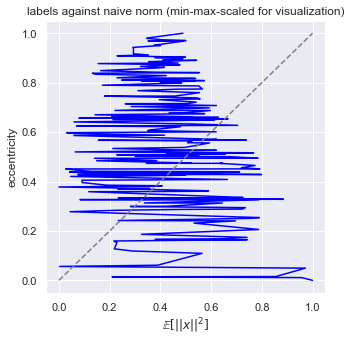

In [330]:
example.compute_plot_naive_norms()

**Subsample the paths**

We can decide to:
- select uniformly, randomly, a set of indices. We choose the same observation grid for each item in a bag. 
- select the first $\ell$ observations


In [331]:
example.subsample_paths(N=100)
#example.plot_subsampled_paths(N=2)

**Test/Train split**

In [332]:
reload(utils)
noisy_labels = example.labels #+0.05*np.random.randn(len(example.labels),1)
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(noisy_labels,example.paths_sub,standardized=True,method='stratify')

**Regression GP-RBF**

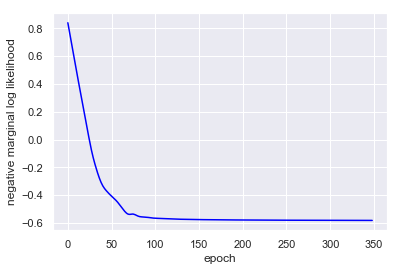

lengtshcale Parameter containing:
tensor([3.3294], dtype=torch.float64, requires_grad=True)
noise_obs Parameter containing:
tensor([-7.2954], dtype=torch.float64, requires_grad=True)


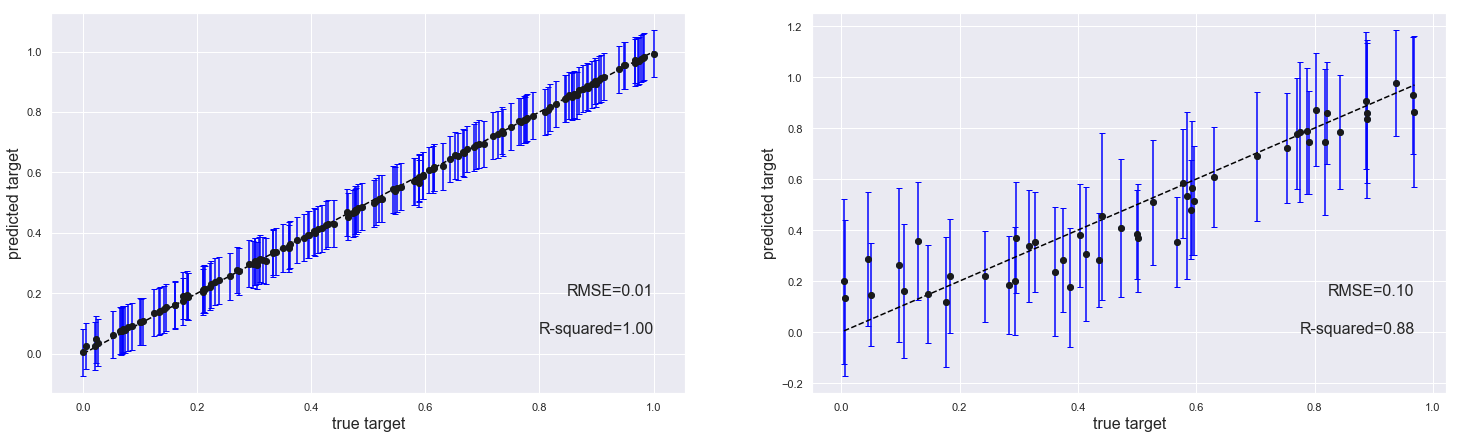

0.8797228718896277


In [338]:
reload(GP_naive)
reload(experiments)
res = []


# stack dimensions
dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
input_ = np.concatenate([dim_1,dim_2],axis=2)


train_naive, test_naive = experiments.naive_experiment(input_, y_scaled ,train_indices,test_indices,param_init=[10,0,0],plot=True)
res.append(test_naive)

print(np.mean(res))

**Regression GP-Sig**

maxi 2000.0


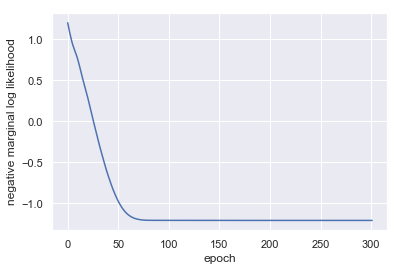

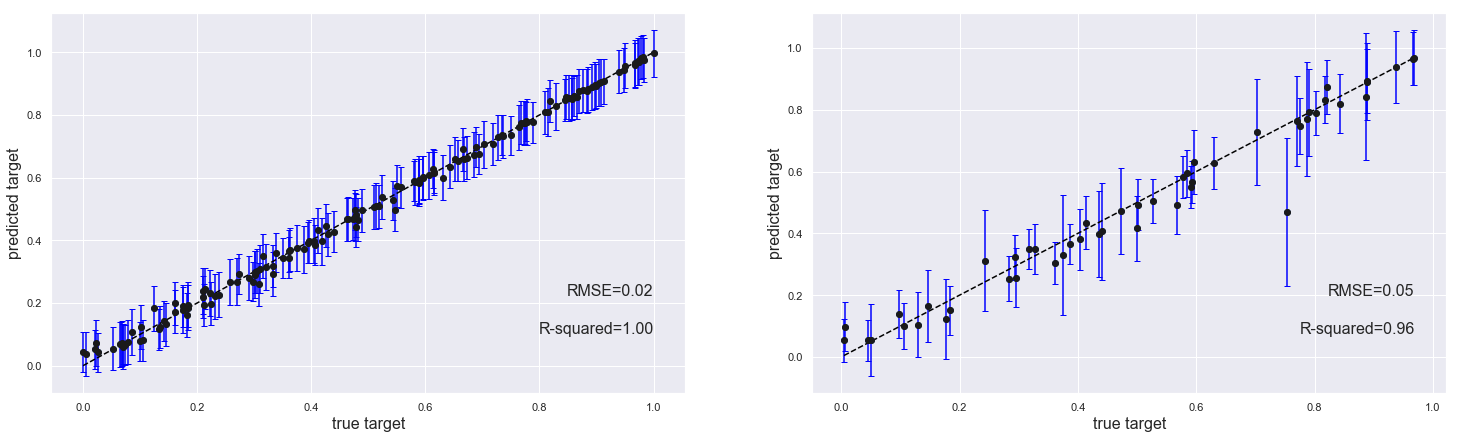

0.9646697168349754


In [333]:
# # specs for expected sig 
reload(signature_features)
reload(experiments)
reload(GP_sig)
sig_level1 = 6
M = 1000

results = []



# pathwise expected sig  
expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
K_precomputed = experiments.precompute_K(expected_pathwise_sig)
train, test = experiments.experiment_precomputed(K_precomputed, y_scaled,train_indices,test_indices, RBF=True,plot=True)
results.append(test)

print(np.mean(results))
      

**Loss landscape**

In [336]:
# reload(GP_naive)
# reload(experiments)
# res = []


# # stack dimensions
# dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
# dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
# input_ = np.concatenate([dim_1,dim_2],axis=2)


# experiments.loss_naive(input_, y_scaled ,train_indices,test_indices)


In [337]:
# reload(signature_features)
# reload(experiments)
# reload(GP_sig)
# sig_level1 = 6
# M = 1000

# results = []



# # pathwise expected sig  
# expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
# K_precomputed = experiments.precompute_K(expected_pathwise_sig)
# experiments.loss_sig(K_precomputed, y_scaled, train_indices,test_indices)


# Comparison Sig-Kernel and RBF-Kernel

- evolution of performances with number of items
- evolution of performances with length time series
- evolution of performances with variance of centre ellipse
- evolution of performances with noise variance